In [186]:
import scipy.spatial as spt
import numpy.linalg as la

def compute_squared_EDM_method5(X):
    V = spt.distance.pdist(X, 'sqeuclidean')
    return spt.distance.squareform(V)

def compute_squared_EDM_method5_modified(X):
    V = spt.distance.pdist(X, 'sqeuclidean')
    V = spt.distance.squareform(V)
    return spt.distance.squareform(V)

def compute_squared_EDM_method1(X):
    # determine dimensions of data matrix X
    m,n = X.shape
    # initialize squared EDM D
    D = np.zeros((n,n))
    # iterate over upper triangle of D
    for i in range(n):
        for j in range(i+1,n):
            D[i,j] = la.norm(X[:,i] - X[:,j])**2
            D[j,i] = D[i,j]
    return D

def compute_norm_2(rows):
    N = np.zeros((len(rows),len(rows)))
    for i in range(1,len(rows)):
        j = 0
        while j<i:
            norm = 0
            norm = rows[i] - rows[j]
            norm = np.sqrt(norm[0]**2+norm[1]**2)
            N[i,j] = norm
            j+=1
    return N

def k_search(pts, l_c):
    knn = np.zeros((len(pts),1), dtype=int)
    index = 0
    for rows in pts:
        knn[index] = np.count_nonzero(rows[np.where(rows<l_c)])
        index+=1
    return knn

In [187]:
import pickle
import numpy as np
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
flag = 0
for i in range(0,24):
    num = "0"+str(i) if i<10 else str(i)
    temp = pickle.load( open( "RA_DEC/"+num+".p", "rb" ) )
    if flag==0:
        t = temp
        flag=1
    else:
        t = vstack([t, temp])

In [188]:
t.sort('RA')
t['RA'] = t['RA']*15

<IPython.core.display.Javascript object>


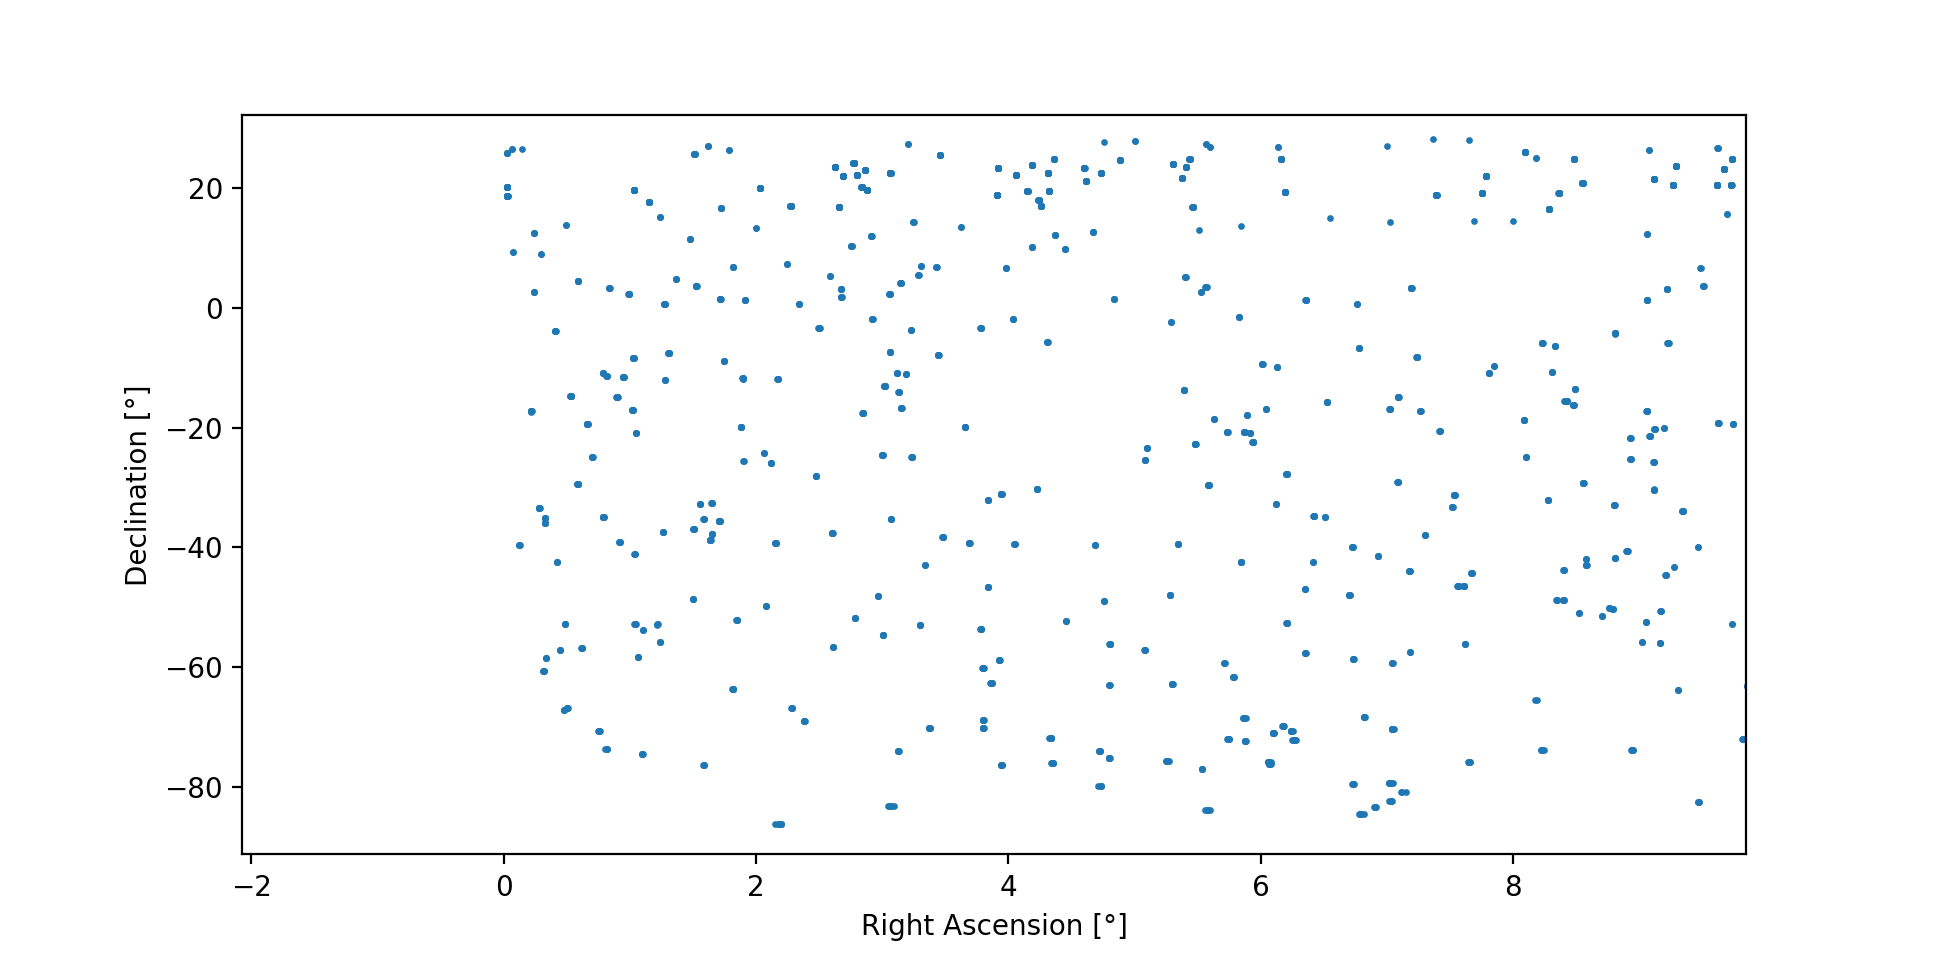

In [4]:
%matplotlib notebook
plt.scatter(t['RA'],t['DEC'],s=2)
plt.xlabel("Right Ascension [°]")
plt.ylabel("Declination [°]")
center = 0.2
l = 1
innerRadio = l
outerRadio = l*(2+np.sqrt(2))/2

In [189]:
# parametros a definir
margin_x = 1
margin_y = 1
subregions_x = 10
subregions_y = 10
data = t
x_0 = min(data['RA'])
x_n = max(data['RA'])
y_0 = min(data['DEC'])
y_n = max(data['DEC'])

# se definen en base a lo definido anteriormente
s = (subregions_y,subregions_x)
sectores = np.zeros(s,dtype=int)
l_x = (x_n-x_0-2*margin_x)/subregions_x
l_y = (x_n-x_0-2*margin_x)/subregions_x

In [13]:
def testing_method1(t,lim,corte):
    try:
        data = t[0:lim]
        margin_x = 1
        margin_y = 1
        x_0 = min(data['RA'])
        x_n = max(data['RA'])
        y_0 = min(data['DEC'])
        y_n = max(data['DEC'])
        l_c = corte

        zona_operacion = [(x_0+margin_x, y_0+margin_y), (x_n-margin_x, y_n-margin_y)]
        puntos=[]
        for coordenada in data:
            puntos.append([coordenada[0],coordenada[1]])
        puntos = np.array(puntos)
        distancias = compute_squared_EDM_method5(puntos)

        cond_x = (puntos[0:-1,0]>= zona_operacion[0][0])&(puntos[0:-1,0]<= zona_operacion[1][0])
        cond_y = (puntos[0:-1,1]>= zona_operacion[0][1])&(puntos[0:-1,0]<= zona_operacion[1][1])
        mask = np.where(cond_x&cond_y)
        puntos_interes = puntos[mask]
        distancias_interes = distancias[mask]

        knn_1 = k_search(distancias_interes,l_c)
        
        return np.append(puntos_interes, knn_1, axis=1)
    #mask_2 = np.where(knn_1>5)
    except:
        return np.zeros((1,1),dtype=int)
        


In [37]:
puntos = []
for coordenada in t:
    puntos.append([coordenada[0]*15,coordenada[1]])
puntos = np.array(puntos)

In [89]:
t['RA'][7000:8000]

30.028814999999998
30.029159999999997
30.029220000000002
30.029339999999998
30.02946
30.02961
30.02997
30.030015
30.030135
30.030255
30.030405000000002


In [16]:
rows = []
data = t
increments = int(len(data)/10)
for i in range(1000,8001,1000):
    res = testing_method1(data, i, 1)
    n = i
    rows.append([res,n])

In [45]:
rows

[[array([[ 1.02744 , -8.311936, 19.      ],
         [ 1.028205, -8.312104, 19.      ],
         [ 1.028415, -8.31335 , 19.      ],
         ...,
         [ 3.056415,  2.333106, 16.      ],
         [ 3.0591  ,  2.331924, 16.      ],
         [ 3.05937 ,  2.329653, 16.      ]]), 1000],
 [array([[  1.02744 ,  -8.311936,  19.      ],
         [  1.028205,  -8.312104,  19.      ],
         [  1.028415,  -8.31335 ,  19.      ],
         ...,
         [  8.104995, -24.876037,   7.      ],
         [  8.105085, -24.876244,   7.      ],
         [  8.105565, -24.877465,   7.      ]]), 2000],
 [array([[  1.02744 ,  -8.311936,  19.      ],
         [  1.028205,  -8.312104,  19.      ],
         [  1.028415,  -8.31335 ,  19.      ],
         ...,
         [ 12.07164 , -28.088729,  10.      ],
         [ 12.071865, -28.088454,  10.      ],
         [ 12.073425, -28.087864,  10.      ]]), 3000],
 [array([[  1.02744 ,  -8.311936,  19.      ],
         [  1.028205,  -8.312104,  19.      ],
         

In [ ]:
array([[ 1.02744 , -8.311936, 19.      ],
       [ 1.028205, -8.312104, 19.      ],
       [ 1.028415, -8.31335 , 19.      ],
       ...,
       [27.26829 , 20.086864, 19.      ],
       [27.268755, 20.087332, 19.      ],
       [27.26955 , 20.084303, 19.      ]])

In [74]:
t = %timeit -o testing_method1(t,3000,1)

[8.692387720002444e-07,
 8.865362480009936e-07,
 9.358539559998462e-07,
 9.130761870001152e-07,
 8.653828730002715e-07,
 8.85032191999926e-07,
 9.314379160005046e-07]

In [46]:
from scipy.spatial import distance_matrix
import time

start = time.clock()
M = distance_matrix(rows, rows)
end = time.clock()
print(end - start)

2.029956000000027


In [47]:
start = time.clock()
A = compute_norm_2(rows)
end = time.clock()
print(end - start)

KeyboardInterrupt: 

In [ ]:
A = np.sqrt(compute_squared_EDM_method5(rows))

In [66]:
%timeit A = compute_squared_EDM_method5(rows)

386 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [128]:
Data = M

In [133]:
data_s = np.sort(Data)

In [144]:
data_s[100]

array([0.00000000e+00, 1.97448728e-04, 4.61009761e-04, ...,
       8.08337050e+01, 8.09709348e+01, 8.11069831e+01])

# Obtención de KNN
## 1er approach: Distancia de todos con todos, qué tan costoso puede ser?
### Cálculo de la matríz distancia
Utilizando un arreglo (`rows`) de 3447 puntos bidimensionales se procede.
#### Usando compute_norm_2
Se usa el cálculo normal mediante for dentro de for, haciendo solo cálculos para la matríz diagonal superior.

    def compute_norm_2(rows):
        N = np.zeros((len(rows),len(rows)))
        for i in range(1,len(rows)):
            j = 0
            while j<i:
                norm = 0
                norm = rows[i] - rows[j]
                norm = np.sqrt(norm[0]**2+norm[1]**2)
                N[i,j] = norm
                j+=1
        return N

resultado con timeit:

    13.3 s ± 239 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    
#### Usando spt distance_matrix
    from scipy.spatial import distance_matrix
    distance_matrix(rows, rows)
resultado con timeit:

    488 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

#### Usando método 5, norma al cuadrado
    import scipy.spatial as spt
    def compute_squared_EDM_method5(X):
        V = spt.distance.pdist(X, 'sqeuclidean')
        return spt.distance.squareform(V)
resultado con timeit:

    85.7 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

#### Usando método 5, extrayendo raíz cuadrada
    np.sqrt(compute_squared_EDM_method5(rows))
resultado con timeit:
    
    115 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)





## 2do approach: Implementación de estrategia de ataque

### Estrategia 1
#### Pasos:
* Definir parámetros

In [111]:
# parametros a definir
margin_x = 1
margin_y = 1
l_c = 1
data = t[0:24000]
x_0 = min(data['RA'])
x_n = max(data['RA'])
y_0 = min(data['DEC'])
y_n = max(data['DEC'])

* Obtener matríz de diferencias

In [ ]:
zona_operacion = [(x_0+margin_x, y_0+margin_y), (x_n-margin_x, y_n-margin_y)]
puntos=[]
for coordenada in data:
    puntos.append([coordenada[0],coordenada[1]])
puntos = np.array(puntos)
distancias = compute_squared_EDM_method5(puntos)

* Filtrar con los márgenes

In [ ]:
cond_x = (puntos[0:-1,0]>= zona_operacion[0][0])&(puntos[0:-1,0]<= zona_operacion[1][0])
cond_y = (puntos[0:-1,1]>= zona_operacion[0][1])&(puntos[0:-1,0]<= zona_operacion[1][1])
mask = np.where(cond_x&cond_y)
puntos_interes = puntos[mask]
distancias_interes = distancias[mask]

* Buscar los k-vecinos mas cercanos para una distancia l_c utilizando
```
def k_search(pts, l_c):
    knn = np.zeros((len(pts),1), dtype=int)
    index = 0
    for rows in pts:
        knn[index] = np.count_nonzero(rows[np.where(rows<l_c)])
        index+=1
    return knn ```

In [ ]:
def k_search(pts, l_c):
    knn = np.zeros((len(pts),1), dtype=int)
    index = 0
    for rows in pts:
        knn[index] = np.count_nonzero(rows[np.where(rows<l_c)])
        index+=1
    return knn
knn_1 = k_search(distancias_interes,l_c)

* Finalmente juntar esta información con los puntos correspondientes

In [ ]:
resultado = np.append(puntos_interes, knn_1, axis=1)

    array([[ 1.02744 , -8.311936, 19.      ],
           [ 1.028205, -8.312104, 19.      ],
           [ 1.028415, -8.31335 , 19.      ],
           ...,
           [27.48597 , -8.194771, 11.      ],
           [27.485985, -8.195136, 11.      ],
           [27.489495, -8.200164, 11.      ]])

### Estrategia 1.1

* Definir parámetros

In [196]:
# parametros a definir
l_c = 1
data = t

* Se calculan las longitudes de la zona de operación

In [197]:
x_0 = min(data['RA'])
x_n = max(data['RA'])
y_0 = min(data['DEC'])
y_n = max(data['DEC'])
l_x = (x_n-x_0)/l_c
l_y = (y_n-y_0)/l_c

* Se crea la matriz de sectores

In [198]:
subregions_x = int(l_x/l_c) if l_x%l_c == 0 else int(l_x/l_c+1)
subregions_y = int(l_y/l_c) if l_y%l_c == 0 else int(l_y/l_c+1)
s = (subregions_y,subregions_x)
sectores = np.zeros(s,dtype=int)

* Se rellena con 1 los limites (que se usarán como margen)

In [199]:
sectores[0,:] = 1
sectores[-1,:] = 1
sectores[:,0] = 1
sectores[:,-1] = 1

* Se inicializa la(s) ventana(s) deslizantes

In [125]:
for col in range(np.shape(sectores)[1]):
    xcenter = col*l_c+0.5*l_c
    xlim_izq = xcenter-1.5*l_c
    xlim_der = xcenter+1.5*l_c
    for row in range(np.shape(sectores)[0]):
        y_0inf = int(y_0) if y_0%1 == 0 else int(y_0-1)
        ycenter = row*l_c+0.5*l_c+y_0inf
        ylim_inf = ycenter-1.5*l_c
        ylim_sup = ycenter+1.5*l_c
        
        if sectores[row][col] == 1:
            continue
        else:
            sectores[row][col] = 1
            cond_x = (data['RA']>= xlim_izq)&(data['RA']<xlim_der)
            cond_y = (data['DEC']>= ylim_inf)&(data['DEC']< ylim_sup)
            mask = np.where(cond_x&cond_y)
            data_aux = np.array(data[mask])
            coordx = np.expand_dims(np.array(data_aux['RA']),axis=1)
            coordy = np.expand_dims(np.array(data_aux['DEC']),axis=1)
            data_aux = np.append(coordx,coordy,axis=1)

In [303]:
y_0inf = int(y_0) if y_0%1 == 0 else int(y_0-1)
cond_x = (data['RA']>= 0)&(data['RA']<3)
cond_y = (data['DEC']>= 2*l_c+0.5*l_c+y_0inf-1.5*l_c)&(data['DEC']< 2*l_c+0.5*l_c+y_0inf+1.5*l_c)
mask = np.where(cond_x&cond_y)
data_aux = data[mask]
coordx = np.expand_dims(np.array(data_aux['RA']),axis=1)
coordy = np.expand_dims(np.array(data_aux['DEC']),axis=1)
data_aux = np.append(coordx,coordy,axis=1)

In [304]:
data_aux

array([[  2.15007 , -86.188648],
       [  2.175735, -86.18894 ],
       [  2.17941 , -86.188945],
       [  2.184645, -86.188539],
       [  2.18631 , -86.188604],
       [  2.19189 , -86.187773],
       [  2.194335, -86.18811 ],
       [  2.195055, -86.188874],
       [  2.196495, -86.188686],
       [  2.199495, -86.18835 ],
       [  2.20095 , -86.189003]])

(11, 1)

In [ ]:
compute_squared_EDM_method5(np.array(data_aux))
array([[ 1.02744 , -8.311936, 19.      ],
       [ 1.028205, -8.312104, 19.      ],
       [ 1.028415, -8.31335 , 19.      ],
       ...,
       [27.48597 , -8.194771, 11.      ],
       [27.485985, -8.195136, 11.      ],
       [27.489495, -8.200164, 11.      ]])


### Estrategia 2
#### Pasos:
* Definir parámetros
* Obtener datos solo para la zona que se analizará
* Inicializar matríz de sectores
* Calcular matríz distancia por sectores de operación